# Household Energy Demand Predictions for IoT Systems

## Datasource:

**Individual household electric power consumption Data Set**
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [49]:
import pandas as pd

data_base = pd.read_csv("./data/household_power_consumption.txt",
                        header=0,
                        squeeze=True,
                        delimiter=";",
                        na_values=["?"],
                        dtype={
                            "Time": str,
                            "Date": str,
                            "Global_active_power": float,
                            "Global_reactive_power": float,
                            "Voltage": float,
                            "Global_intensity": float,
                            "Sub_metering_1": float,
                            "Sub_metering_2": float,
                            "Sub_metering_3": float
                        })

data_base["timestamp"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base["date_filter"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base = data_base.set_index("timestamp")

data_base.head(5).style

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_filter
timestamp,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216000,0.418000,234.840000,18.400000,0.000000,1.000000,17.000000,2006-12-16 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360000,0.436000,233.630000,23.000000,0.000000,1.000000,16.000000,2006-12-16 17:25:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374000,0.498000,233.290000,23.000000,0.000000,2.000000,17.000000,2006-12-16 17:26:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388000,0.502000,233.740000,23.000000,0.000000,1.000000,17.000000,2006-12-16 17:27:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666000,0.528000,235.680000,15.800000,0.000000,1.000000,17.000000,2006-12-16 17:28:00


## Filtering the Dataset

* *Start Date:* lower time boundary (inclusive).
* *End Date:* upper time boundary (exclusive).
* *Feature:* selected field for the univariate time series analysis.

In [50]:
start_date = "2007-01-01"
end_date = "2007-01-16"
feature = "Global_active_power"

def clean_data(dataframe):
    date_range = (data_base["date_filter"] >= start_date) & (data_base["date_filter"] < end_date)
    return dataframe.dropna(subset=[feature]).loc[date_range].resample("60min", on="date_filter").median()[feature]

series = clean_data(data_base)

## Dataset Exploration

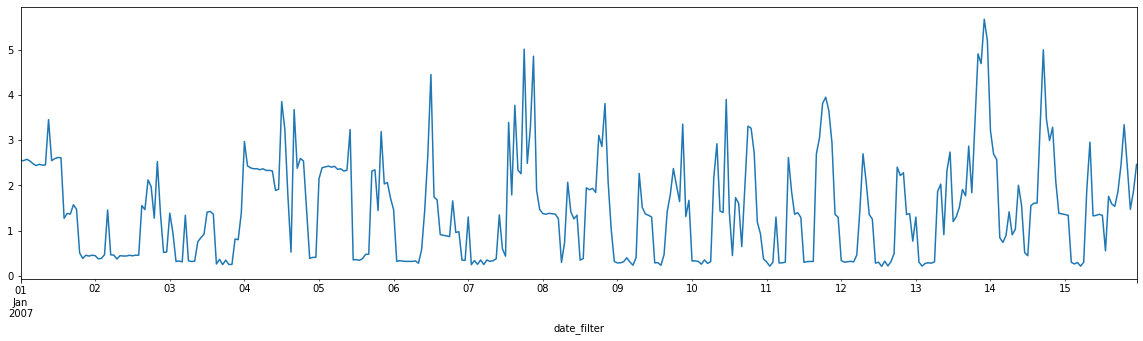

In [51]:
import matplotlib as plt
plt.rcParams["figure.figsize"] = (20,5)

series.plot()
plt.pyplot.show()

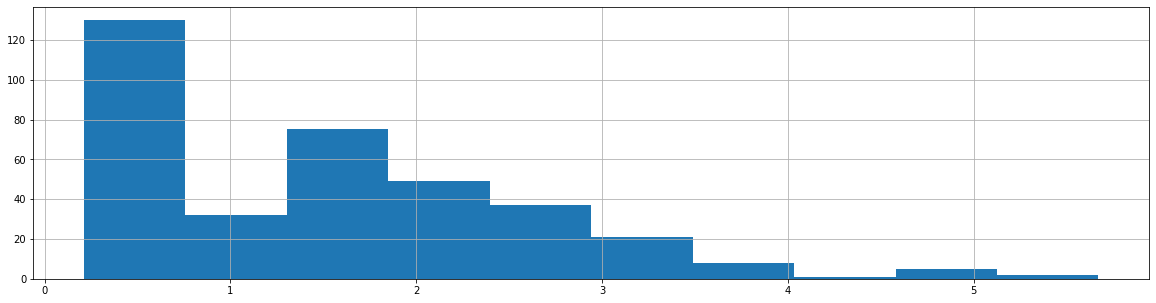

In [52]:
series.hist()
plt.pyplot.show()

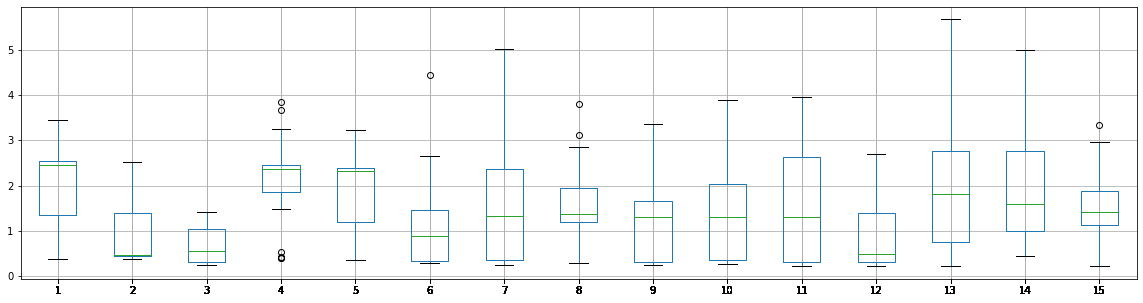

In [53]:
pd.DataFrame(series).set_index(series.index.day, append=True).unstack().boxplot()
plt.pyplot.xticks(series.index.day, list(series.index.day))
plt.pyplot.show()

**Lag Plot (t + 1):** check the correlation of time shifted measurements (each increment is the median value of a 1 hour sample).

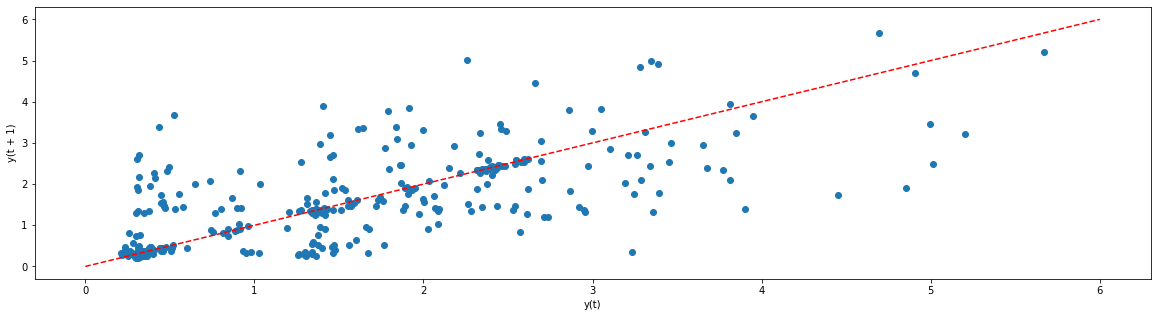

In [54]:
pd.plotting.lag_plot(series)
ident = [0.0, 6.0]
plt.pyplot.plot(ident,ident, color="red", linestyle="--")
plt.pyplot.show()

**Autocorrelation Plot:** discover the behaviour of autocorrelation scores according to time lags.

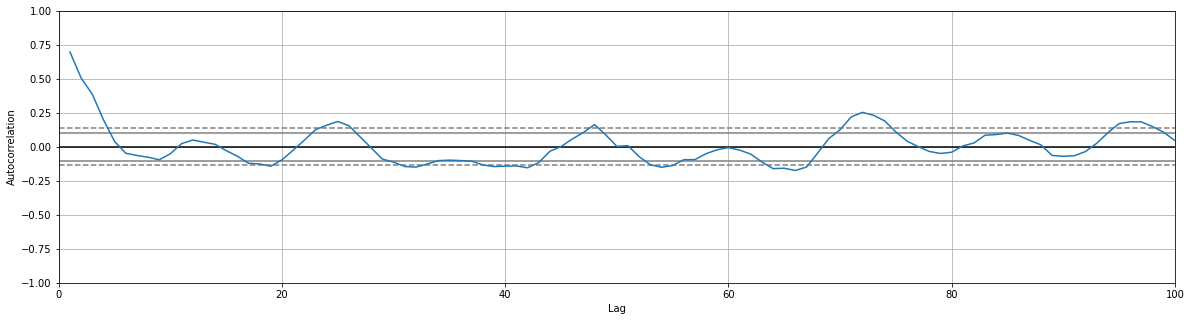

In [55]:
pd.plotting.autocorrelation_plot(series)
plt.pyplot.xlim([0,100])
plt.pyplot.show()

**Seasonal Decomposition:** check global trends and seasonal patterns.

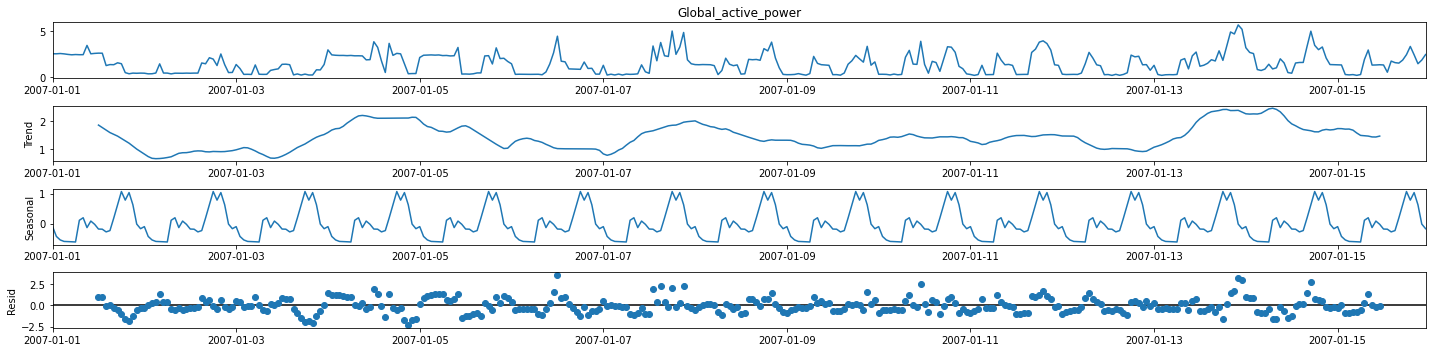

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(series, model='additive').plot()
plt.pyplot.show()

**Augmented Dickey Fuller Test (ADF Test):** hypothesis test for dataset stationarity (lower the *p-value* the better).

In [57]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]:0.10f}")
print('Critical Values:')
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -7.489241483537777
p-value: 0.0000000000
Critical Values:
	1%: -3.448905534655263
	5%: -2.8697161816205705
	10%: -2.5711258103550882


**Baseline Model:** find the error rate of the most obvious algorithm [Y(t+1) = Y(t)]

In [58]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head(5)

,t,t+1
0,NaN,2.550
1,2.550,2.548
2,2.548,2.578
3,2.578,2.539
4,2.539,2.481


In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = dataframe.values
train_size = int(len(X) * 0.7)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_baseline(x):
  return x

def RMSE(expected, predicted):
    return sqrt(mean_squared_error(expected, predicted))

def validate_model(model, cost, expected, validation):
    p = [model(x) for x in validation]
    return cost(expected, p), p

error, predictions = validate_model(model=model_baseline,
                                    cost=RMSE,
                                    expected=test_y,
                                    validation=test_X)

print(f"Baseline RMSE: {error}")

Baseline RMSE: 0.8203150882659036


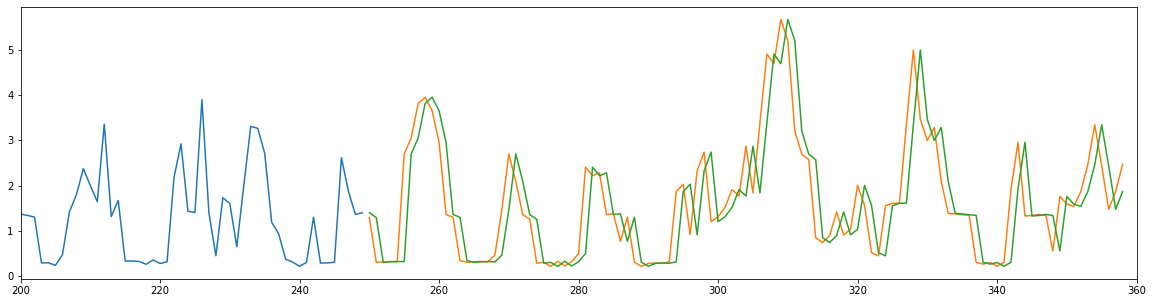

In [60]:
plt.pyplot.plot(train_y)
plt.pyplot.plot([None for i in train_y] + [x for x in test_y])
plt.pyplot.plot([None for i in train_y] + [x for x in predictions])
plt.pyplot.xlim([200,360])
plt.pyplot.show()